In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser
import os

In [2]:
# DATA

# import

station_id=5001
file_path = os.path.join(r'D:\FMF magisterij\Matematika z računalnikom', f'ELES-MAS-{station_id}-2020-2023.csv.gz')
data = pd.read_csv(file_path, compression='gzip')
data = data[data['data_validity'] <= 32]
data.drop('measurement_location_inst_id', axis=1, inplace=True)
data['acquisition_timestamp'] = pd.to_datetime(data['acquisition_timestamp'], utc=True)


In [3]:
# pivoting
new_data = data.pivot_table(index='acquisition_timestamp', columns='parameter_type', values='value').reset_index()
new_data.set_index('acquisition_timestamp', inplace=True)


# wind_speed
wind_speed = new_data[['WIND_SPEED']]
print(wind_speed)

# count the NaN values
nan_count_wind_speed = wind_speed['WIND_SPEED'].isna().sum()
print(nan_count_wind_speed)
# there are 7156 NaN values
# fill them with backfill
wind_speed = wind_speed.fillna(method='bfill')
print(wind_speed.isna().sum())

# check for missing measurements (skipped times)
complete_range = pd.date_range(start=wind_speed.index.min(), end=wind_speed.index.max(), freq='5T')
missing_timestamps = complete_range.difference(wind_speed.index)
print(len(missing_timestamps))
#print(complete_range)
df_complete_range = pd.DataFrame(index=complete_range)
len(df_complete_range)
# we have 271508 measurements, there are 5112 missing measurment out of 276620 time steps in the whole time range

# fill the missing measurements with the measurment at that time on the previous day (!problem: if the measurment of the previous day at that time is also missing. solution: take the next day)

# merge all the air pressure measurements with all the time steps. missing measurment will be NaN values for now
wind_speed_incomplete = df_complete_range.merge(wind_speed, left_index=True, right_index=True, how='left')
# print(wind_speed_incomplete)
wind_speed_incomplete.isna().sum() # okay

# missing measurements are filled with the next available measurement
wind_speed_all = wind_speed_incomplete.bfill()
print(wind_speed_all)
wind_speed_all.isna().sum() # okay

str(wind_speed_all.index.dtype) # okay

parameter_type             WIND_SPEED
acquisition_timestamp                
2020-10-13 10:20:00+00:00         NaN
2020-10-13 10:25:00+00:00        2.45
2020-10-13 10:30:00+00:00        2.81
2020-10-13 10:35:00+00:00        3.28
2020-10-13 10:40:00+00:00        1.27
...                               ...
2023-05-31 21:35:00+00:00        0.17
2023-05-31 21:40:00+00:00        0.12
2023-05-31 21:45:00+00:00        0.21
2023-05-31 21:50:00+00:00        0.04
2023-05-31 21:55:00+00:00        0.18

[271508 rows x 1 columns]
7156
parameter_type
WIND_SPEED    0
dtype: int64
5112
                           WIND_SPEED
2020-10-13 10:20:00+00:00        2.45
2020-10-13 10:25:00+00:00        2.45
2020-10-13 10:30:00+00:00        2.81
2020-10-13 10:35:00+00:00        3.28
2020-10-13 10:40:00+00:00        1.27
...                               ...
2023-05-31 21:35:00+00:00        0.17
2023-05-31 21:40:00+00:00        0.12
2023-05-31 21:45:00+00:00        0.21
2023-05-31 21:50:00+00:00        0.04
2023-05

C:\Users\reginab\AppData\Local\Temp\ipykernel_3748\2098721459.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  wind_speed = wind_speed.fillna(method='bfill')


'datetime64[ns, UTC]'

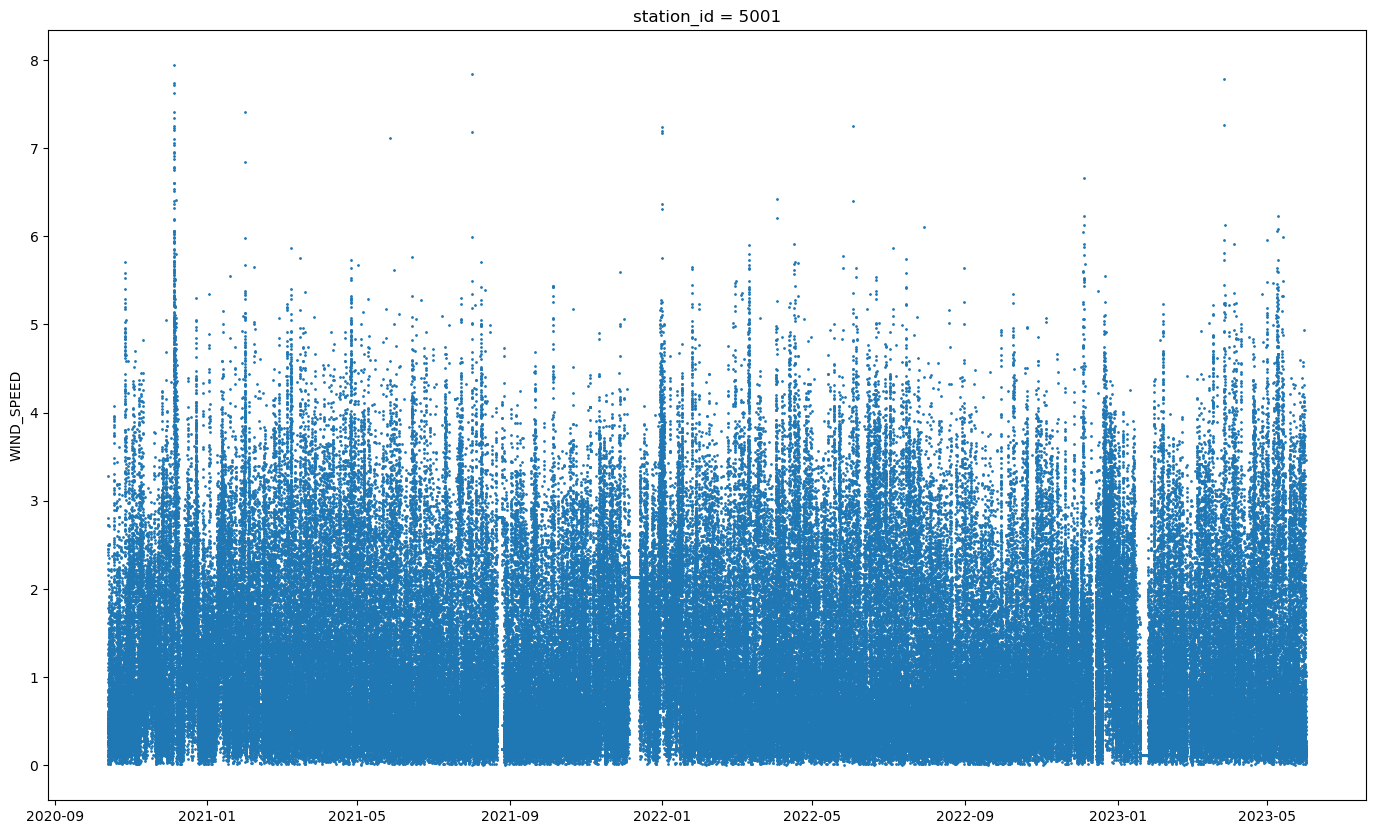

In [4]:
# plot 'WIND_SPEED'
fig, ax = plt.subplots(figsize=(17, 10))
ax.scatter(wind_speed_all.index, wind_speed_all['WIND_SPEED'],s=1)
ax.set_ylabel('WIND_SPEED')  
ax.set_title(f'station_id = {station_id}')  
plt.show()

                           WIND_SPEED
2020-10-13 10:00:00+00:00    2.357500
2020-10-13 11:00:00+00:00    1.675000
2020-10-13 12:00:00+00:00    0.826667
2020-10-13 13:00:00+00:00    0.460833
2020-10-13 14:00:00+00:00    0.477500
...                               ...
2023-05-31 17:00:00+00:00    0.677500
2023-05-31 18:00:00+00:00    0.205000
2023-05-31 19:00:00+00:00    0.899167
2023-05-31 20:00:00+00:00    0.236667
2023-05-31 21:00:00+00:00    0.155833

[23052 rows x 1 columns]


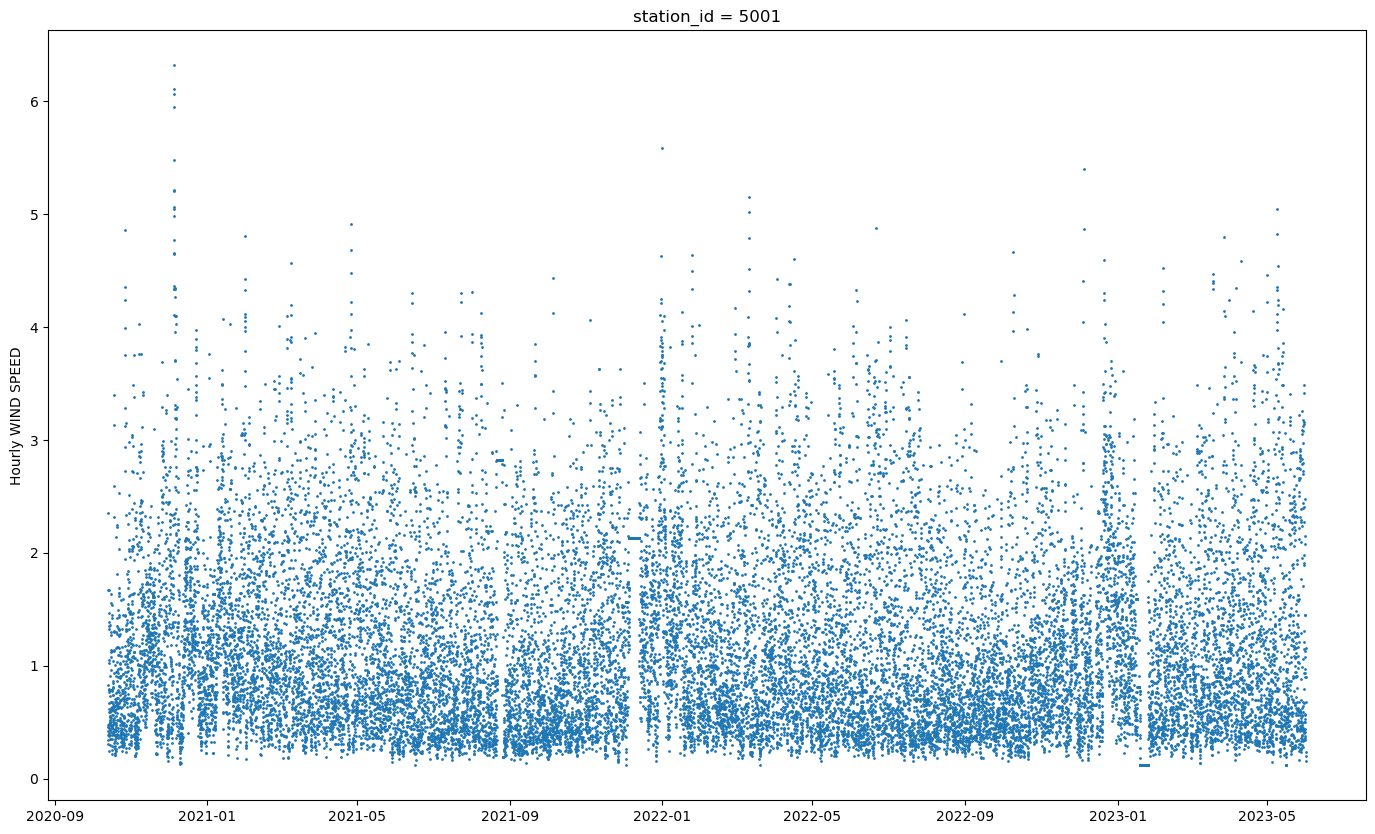

In [5]:
# hourly data
# sum the values for each hour and take the mean

str(wind_speed_all.index.dtype) # okay
wind_speed_hourly = wind_speed_all.resample('H').mean()
print(wind_speed_hourly)

# plot hourly 'WIND_SPEED'
fig, ax = plt.subplots(figsize=(17, 10))
ax.scatter(wind_speed_hourly.index, wind_speed_hourly['WIND_SPEED'],s=1)
ax.set_ylabel('Hourly WIND SPEED')  
ax.set_title(f'station_id = {station_id}')  
plt.show()

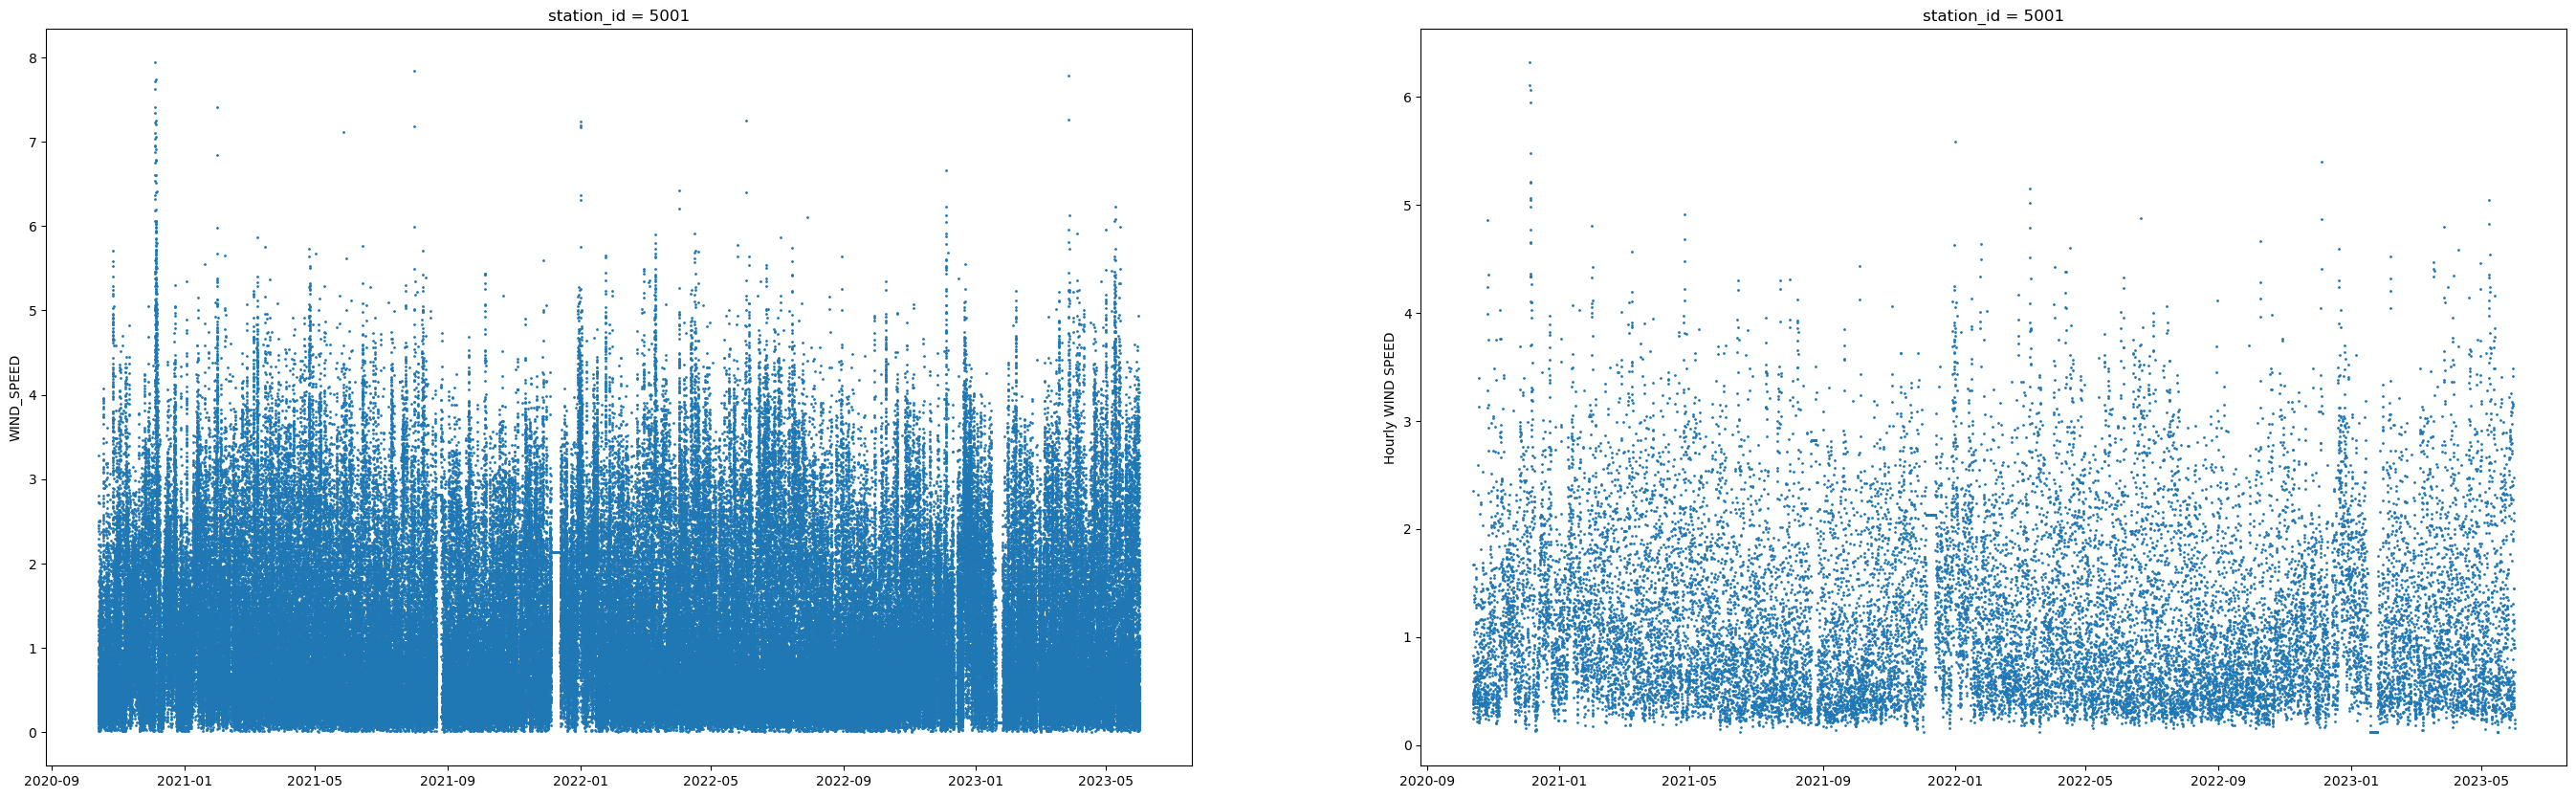

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(34, 10))

axs[0].scatter(wind_speed_all.index, wind_speed_all['WIND_SPEED'],s=1)
axs[0].set_ylabel('WIND_SPEED')  
axs[0].set_title(f'station_id = {station_id}')  

axs[1].scatter(wind_speed_hourly.index, wind_speed_hourly['WIND_SPEED'],s=1)
axs[1].set_ylabel('Hourly WIND SPEED')  
axs[1].set_title(f'station_id = {station_id}')    

plt.show()

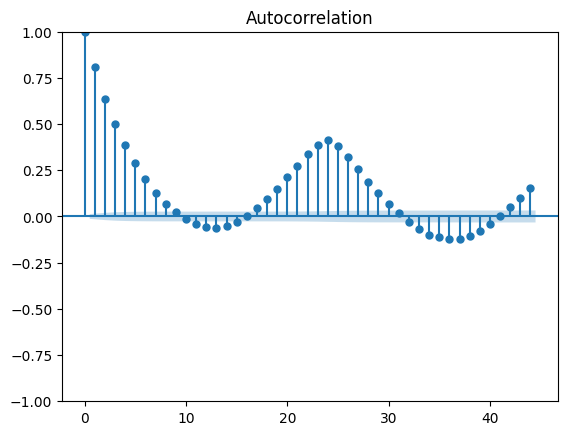

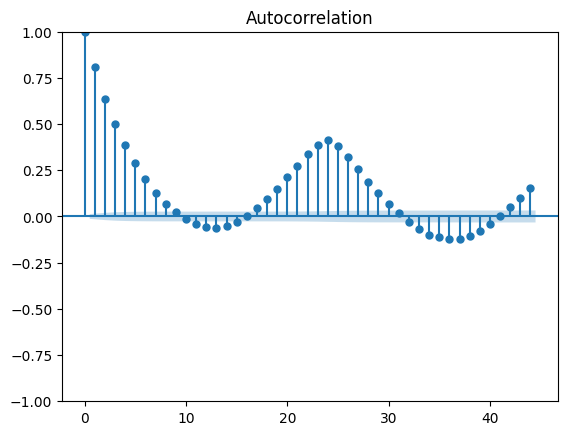

In [6]:
# ARIMA(p, d, q)

# let's look for a suggestion for d by looking at the autocorellation function (ACF) plot

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(wind_speed_hourly['WIND_SPEED'])

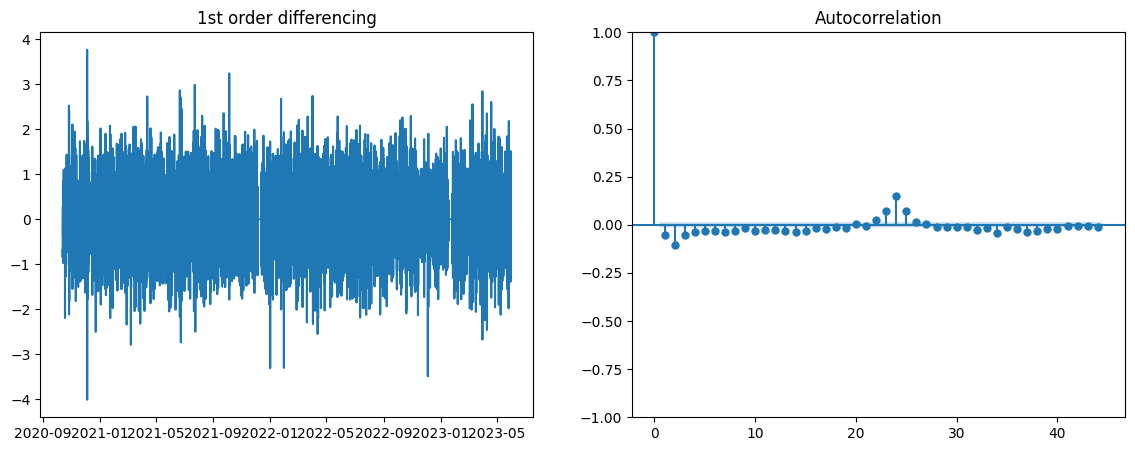

In [7]:
# first differencing and ACF

f = plt.figure(figsize=(14, 5))
ax1 = f.add_subplot(121)
ax1.set_title('1st order differencing')
ax1.plot(wind_speed_hourly['WIND_SPEED'].diff())

ax2 = f.add_subplot(122)
plot_acf(wind_speed_hourly['WIND_SPEED'].diff().dropna(), ax=ax2)
plt.show()


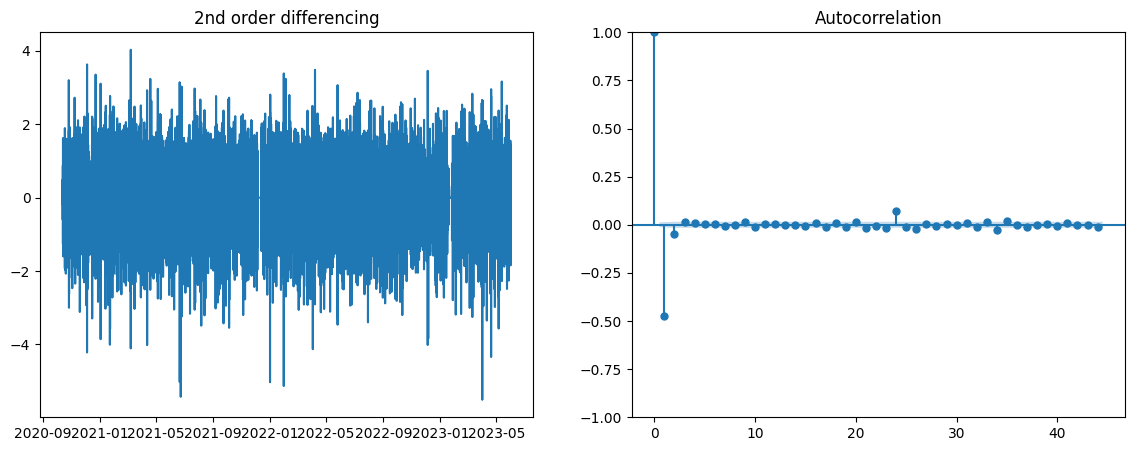

In [8]:
# second differencing and ACF

f = plt.figure(figsize=(14, 5))
ax1 = f.add_subplot(121)
ax1.set_title('2nd order differencing')
ax1.plot(wind_speed_hourly['WIND_SPEED'].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(wind_speed_hourly['WIND_SPEED'].diff().diff().dropna(), ax=ax2)
plt.show()

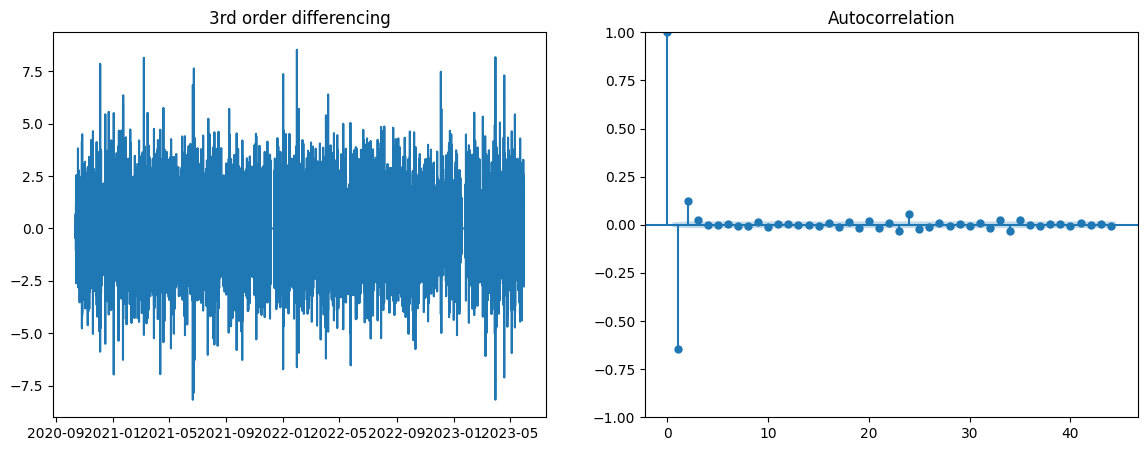

In [9]:
# third differencing and ACF

f = plt.figure(figsize=(14, 5))
ax1 = f.add_subplot(121)
ax1.set_title('3rd order differencing')
ax1.plot(wind_speed_hourly['WIND_SPEED'].diff().diff().diff())

ax2 = f.add_subplot(122)
plot_acf(wind_speed_hourly['WIND_SPEED'].diff().diff().diff().dropna(), ax=ax2)
plt.show()

For deciding the appropriate order of differencing, we can to the Augmented Dickey-Fuller test. (more about it for the report is in the air_pressure files). The ADF test aims to reject the null hypothesis that the given time-series data is non-stationary. It calculates the p-value and compares it with a threshold value or significance level of 0.05. If the p-value is less than this level, then the data is stationary; else, the differencing order is incremented by one.

In [10]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(wind_speed_hourly['WIND_SPEED'].dropna())
print('original data p-value:', result[1])

result = adfuller(wind_speed_hourly['WIND_SPEED'].diff().dropna())
print('1-diff data p-value:', result[1])

result = adfuller(wind_speed_hourly['WIND_SPEED'].diff().diff().dropna())
print('2-diff data p-value:', result[1])

result = adfuller(wind_speed_hourly['WIND_SPEED'].diff().diff().diff().dropna())
print('3-diff data p-value:', result[1])

original data p-value: 2.490970390884912e-25
1-diff data p-value: 0.0
2-diff data p-value: 0.0
3-diff data p-value: 0.0


The data is likely stationary.

Now we will look for the best ARIMA(p,d,q) model to fit to the data.

In [12]:
# 1ST WAY OF FINDING THE BEST FIT

# ARIMA for all the hourly ambient wind_speed data
from pmdarima import auto_arima
stepwise_fit = auto_arima(wind_speed_hourly, trace=True,
suppress_warnings=True)
# it takes around 10 min

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=12.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=34480.484, Time=1.52 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34420.069, Time=0.80 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=34402.804, Time=1.78 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34478.484, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=24.79 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=34078.007, Time=5.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=24.70 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=33919.834, Time=7.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=33.68 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=33576.446, Time=14.81 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=28.17 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=32868.490, Time=18.57 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=32131.820, Time=36.42 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC

                               SARIMAX Results                                
Dep. Variable:             WIND_SPEED   No. Observations:                23052
Model:                 ARIMA(2, 1, 5)   Log Likelihood              -16011.491
Date:                Wed, 22 May 2024   AIC                          32038.982
Time:                        01:24:25   BIC                          32103.345
Sample:                    10-13-2020   HQIC                         32059.896
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1512      0.118     -1.277      0.202      -0.383       0.081
ar.L2          0.6911      0.093      7.469      0.000       0.510       0.872
ma.L1         -0.0047      0.118     -0.040      0.9

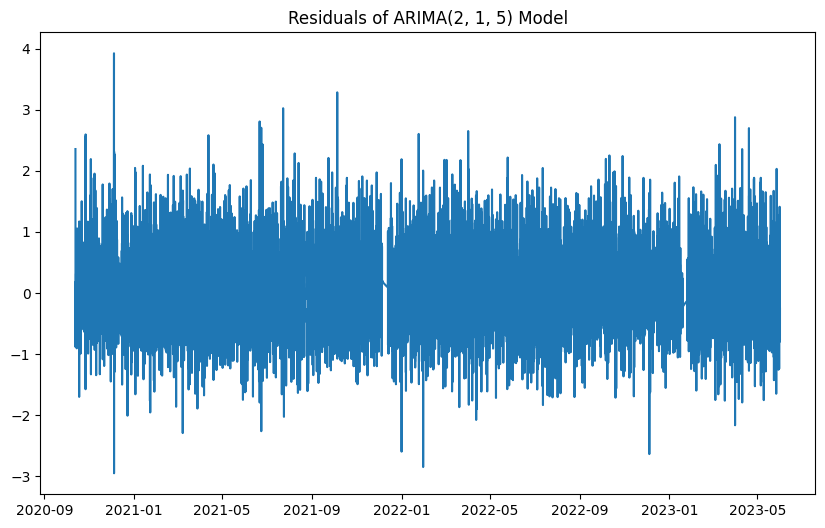

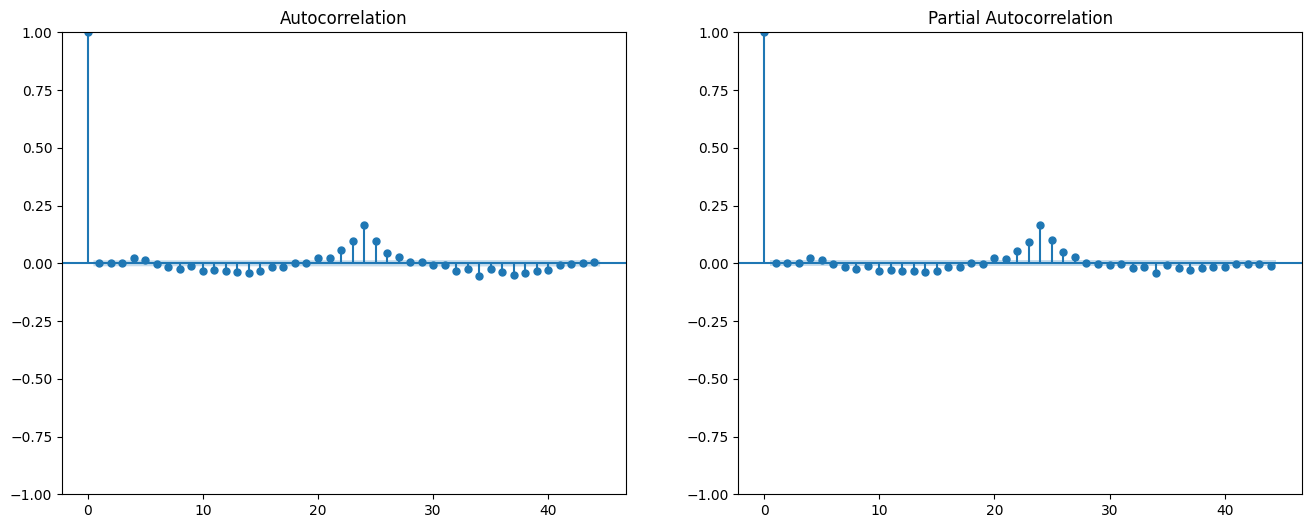

In [11]:
# fit the model 

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# fit the best model
best_model = ARIMA(wind_speed_hourly, order=(2,1,5))   # change order accordingly
best_fit = best_model.fit()

# summary of the best model
print(best_fit.summary())

# residuals of the best model
residuals_best = best_fit.resid

# plot residuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(residuals_best)
plt.title(f'Residuals of ARIMA{2,1,5} Model')
plt.show()

# plot ACF and PACF of the residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(residuals_best, ax=ax[0], alpha=0.05)
plot_pacf(residuals_best, ax=ax[1], alpha=0.05)
plt.show()

        Order           AIC           BIC
77  (4, 0, 5)  30873.681416  30962.182002
95  (5, 0, 5)  30884.819724  30981.365818
76  (4, 0, 4)  30976.015680  31056.470758
59  (3, 0, 5)  31261.446302  31341.901380
58  (3, 0, 4)  31670.740283  31743.149854
Best ARIMA order: (4, 0, 5)
                               SARIMAX Results                                
Dep. Variable:             WIND_SPEED   No. Observations:                23052
Model:                 ARIMA(4, 0, 5)   Log Likelihood              -15425.841
Date:                Mon, 20 May 2024   AIC                          30873.681
Time:                        02:11:21   BIC                          30962.182
Sample:                    10-13-2020   HQIC                         30902.438
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------

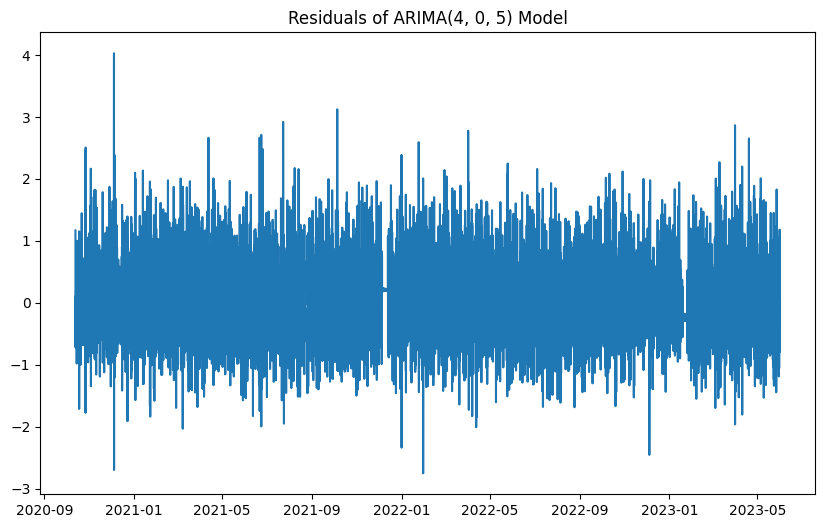

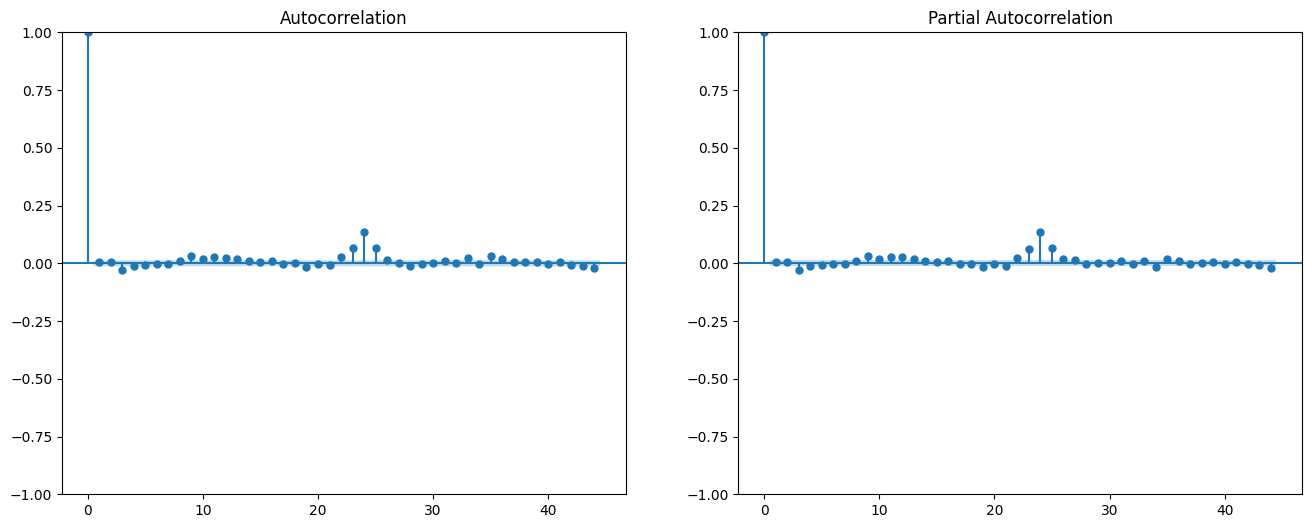

In [14]:
# 2ND WAY OF FINDING THE BEST FIT

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# define the range for p, d, q parameters
p = range(0, 6)
d = range(0, 3)
q = range(0, 6)

# a list to store the results
results = []

# perform grid search
for i in p:
    for j in d:
        for k in q:
            order = (i, j, k)
            try:
                model = ARIMA(wind_speed_hourly, order=order)
                fit = model.fit()
                aic = fit.aic
                bic = fit.bic
                results.append((order, aic, bic))
            except:
                continue

# convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Order', 'AIC', 'BIC'])

# sort the results by AIC and BIC
results_df = results_df.sort_values(by='AIC')

# print the top 5 models
print(results_df.head())

# choose the best model based on the lowest AIC
best_order = results_df.iloc[0]['Order']
print(f"Best ARIMA order: {best_order}")

# fit the best model
best_model = ARIMA(wind_speed_hourly, order=best_order)
best_fit = best_model.fit()

# check the summary of the best model
print(best_fit.summary())

# residuals of the best model
residuals_best = best_fit.resid

# plot residuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(residuals_best)
plt.title(f'Residuals of ARIMA{best_order} Model')
plt.show()

# plot ACF and PACF of the residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(residuals_best, ax=ax[0])
plot_pacf(residuals_best, ax=ax[1])
plt.show()

In [12]:
# data for 2020, 2021, 2022
# fit the best model to this data
# 2 best ARIMAs: (2,1,5) and (4,0,5) - try both
# forecast the next 24 hours 
# compare forecast from ARIMA and simple model with actual values (maybe 2 simple models)
# plot forecasts, plot errors

wind_speed_20_21_22 = wind_speed_hourly.loc[(wind_speed_hourly.index.year == 2020) | (wind_speed_hourly.index.year == 2021) | (wind_speed_hourly.index.year == 2022) , 'WIND_SPEED']
print(wind_speed_20_21_22)

2020-10-13 10:00:00+00:00    2.357500
2020-10-13 11:00:00+00:00    1.675000
2020-10-13 12:00:00+00:00    0.826667
2020-10-13 13:00:00+00:00    0.460833
2020-10-13 14:00:00+00:00    0.477500
                               ...   
2022-12-31 19:00:00+00:00    1.440000
2022-12-31 20:00:00+00:00    1.088333
2022-12-31 21:00:00+00:00    1.333333
2022-12-31 22:00:00+00:00    1.555000
2022-12-31 23:00:00+00:00    1.955833
Freq: H, Name: WIND_SPEED, Length: 19430, dtype: float64


Now we will create a simple models to later compare it with the ARIMA models we fitted to the data.

Simple model: Average of the previous 3 days is the value for the next day.

We fitted ARIMA models to all the hourly data. We will fit the models to the data for just 2020, 2021 and 2022 and then forecast 1 day (24 steps into the 'future', which is the start of the year 2023).

We will then compare the models with the actual data and see which model gives the best forecast. Hopefully it is the ARIMA model.

In [13]:
# 1st simple model
# average of the previous 3 days is the value for the next day

def last_3_days_average(data, forecasted_steps):
    # Forecasts the next values based on the average of the last 3 days at the same time.
    forecast = []

    for step in range(forecasted_steps):

        next_time_step = data.index[-1] + pd.Timedelta(hours=1) # finds out the next time step
        
        last_3_days = [
            next_time_step - pd.Timedelta(days=i) for i in range(1, 4)     # gets the same hour from the last 3 days
        ]
        
        values = [data[data.index == dt].values for dt in last_3_days] # extracts the values at the same hour from the last 3 days
        values = [val[0] if len(val) > 0 else np.nan for val in values]
        
        forecast_value = np.nanmean(values) # mean of the last 3 days
        
        forecast.append(forecast_value)
        
        data = pd.concat([data, pd.Series([forecast_value], index=[next_time_step])]) # adds the forecasted value to the data for the next iteration

    return pd.Series(forecast, index=[data.index[-forecasted_steps + i] for i in range(forecasted_steps)])

last_3_days_average(wind_speed_20_21_22, 24)

last_3_wind_speed = last_3_days_average(wind_speed_20_21_22, 24)

In [14]:
# 2nd simple model
# today's measurement is tomorrow's forecast

def today_is_tomorrow(data, forecasted_steps):

    forecast = []

    for step in range(forecasted_steps):

        next_time_step = data.index[-1] + pd.Timedelta(hours=1)
        
        same_hour_last_day = next_time_step - pd.Timedelta(days=1)
        
        forecast_value = data.loc[same_hour_last_day]
        
        forecast.append(forecast_value)
        
        data = pd.concat([data, pd.Series([forecast_value], index=[next_time_step])])

    return pd.Series(forecast, index=[data.index[-forecasted_steps + i] for i in range(forecasted_steps)])

today_is_tomorrow(wind_speed_20_21_22, 24)

today_is_tomorrow_wind_speed = today_is_tomorrow(wind_speed_20_21_22, 24)

In [15]:
# ARIMA(2,1,5) (1st fit)

# change p,d,q to the best found

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")


# fit
model_215 = ARIMA(wind_speed_20_21_22, order=(2,1,5))
fit_215 = model_215.fit()

# summary of the fit
print(fit_215.summary())

# ARIMA forecast for 1 day (24 steps) into the future

forecast_result_215 = fit_215.get_forecast(steps=24)
forecast_values_215 = forecast_result_215.predicted_mean
conf_int_215 = forecast_result_215.conf_int()

print("Forecasted values:", forecast_values_215)
print("95% Confidence intervals of forecasts:", conf_int_215)

                               SARIMAX Results                                
Dep. Variable:             WIND_SPEED   No. Observations:                19430
Model:                 ARIMA(2, 1, 5)   Log Likelihood              -13535.628
Date:                Wed, 22 May 2024   AIC                          27087.257
Time:                        01:24:36   BIC                          27150.253
Sample:                    10-13-2020   HQIC                         27107.896
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1612      0.137     -1.180      0.238      -0.429       0.107
ar.L2          0.7037      0.107      6.590      0.000       0.494       0.913
ma.L1          0.0023      0.137      0.017      0.9

In [16]:
print(forecast_values_215)

2023-01-01 00:00:00+00:00    1.900904
2023-01-01 01:00:00+00:00    1.822120
2023-01-01 02:00:00+00:00    1.774416
2023-01-01 03:00:00+00:00    1.724575
2023-01-01 04:00:00+00:00    1.690285
2023-01-01 05:00:00+00:00    1.660741
2023-01-01 06:00:00+00:00    1.641376
2023-01-01 07:00:00+00:00    1.623709
2023-01-01 08:00:00+00:00    1.612931
2023-01-01 09:00:00+00:00    1.602237
2023-01-01 10:00:00+00:00    1.596377
2023-01-01 11:00:00+00:00    1.589797
2023-01-01 12:00:00+00:00    1.586734
2023-01-01 13:00:00+00:00    1.582598
2023-01-01 14:00:00+00:00    1.581109
2023-01-01 15:00:00+00:00    1.578439
2023-01-01 16:00:00+00:00    1.577822
2023-01-01 17:00:00+00:00    1.576042
2023-01-01 18:00:00+00:00    1.575895
2023-01-01 19:00:00+00:00    1.574667
2023-01-01 20:00:00+00:00    1.574761
2023-01-01 21:00:00+00:00    1.573881
2023-01-01 22:00:00+00:00    1.574090
2023-01-01 23:00:00+00:00    1.573437
Freq: H, Name: predicted_mean, dtype: float64


In [17]:
# ARIMA(4,0,5) (2nd fit)

# change p,d,q to the best found

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")


# fit
model_405 = ARIMA(wind_speed_20_21_22, order=(4,0,5))
fit_405 = model_405.fit()

# summary of the fit
print(fit_405.summary())

# ARIMA forecast for 1 day (24 steps) into the future

forecast_result_405 = fit_405.get_forecast(steps=24)
forecast_values_405 = forecast_result_405.predicted_mean
conf_int_405 = forecast_result_405.conf_int()

print("Forecasted values:", forecast_values_405)
print("95% Confidence intervals of forecasts:", conf_int_405)


                               SARIMAX Results                                
Dep. Variable:             WIND_SPEED   No. Observations:                19430
Model:                 ARIMA(4, 0, 5)   Log Likelihood              -13097.639
Date:                Wed, 22 May 2024   AIC                          26217.279
Time:                        01:25:04   BIC                          26303.899
Sample:                    10-13-2020   HQIC                         26245.658
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1705      0.020     57.572      0.000       1.131       1.210
ar.L1          1.7628      0.007    249.834      0.000       1.749       1.777
ar.L2          0.1515      0.011     13.815      0.0

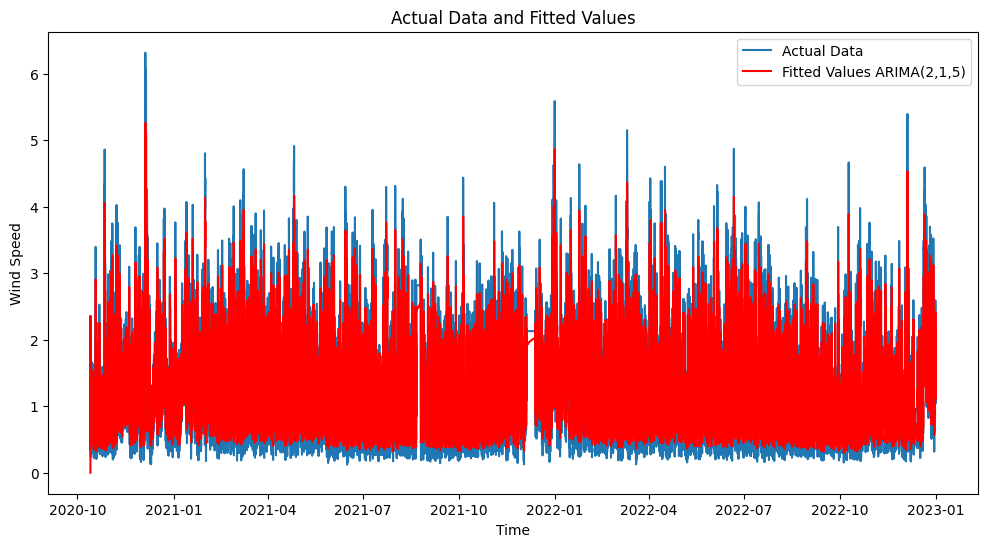

In [18]:
# plot actual data and fitted values - 1ST ARIMA
# change p,d,q to the best found

# fitted values
fitted_values_215 = fit_215.fittedvalues

plt.figure(figsize=(12,6))
plt.plot(wind_speed_20_21_22.index, wind_speed_20_21_22, label='Actual Data')
plt.plot(wind_speed_20_21_22.index, fitted_values_215, color='red', label='Fitted Values ARIMA(2,1,5)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.title('Actual Data and Fitted Values')
plt.show()

# this looks too good

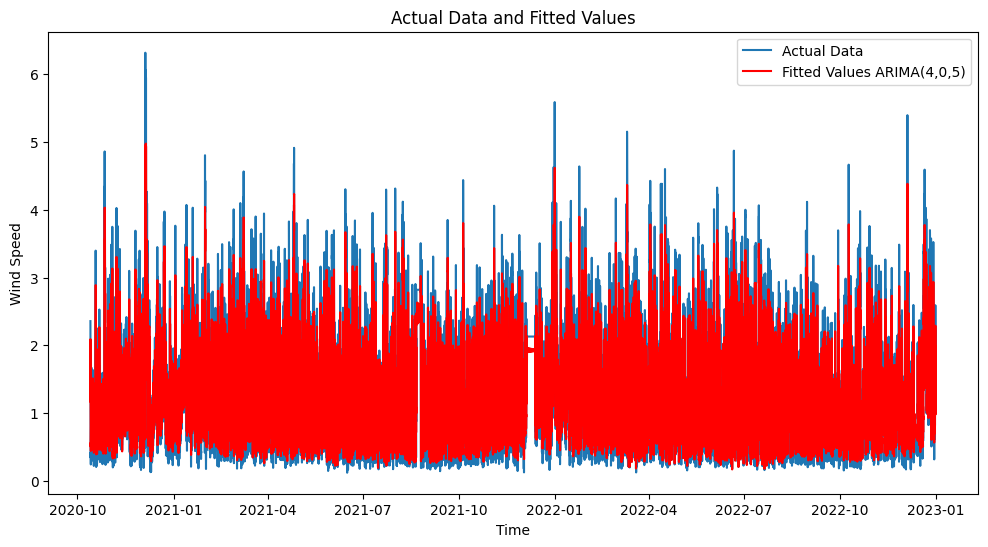

In [19]:
# plot actual data and fitted values - 2ND ARIMA
# change p,d,q to the best found

# fitted values
fitted_values_405 = fit_405.fittedvalues

plt.figure(figsize=(12,6))
plt.plot(wind_speed_20_21_22.index, wind_speed_20_21_22, label='Actual Data')
plt.plot(wind_speed_20_21_22.index, fitted_values_405, color='red', label='Fitted Values ARIMA(4,0,5)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.title('Actual Data and Fitted Values')
plt.show()

# this looks too good

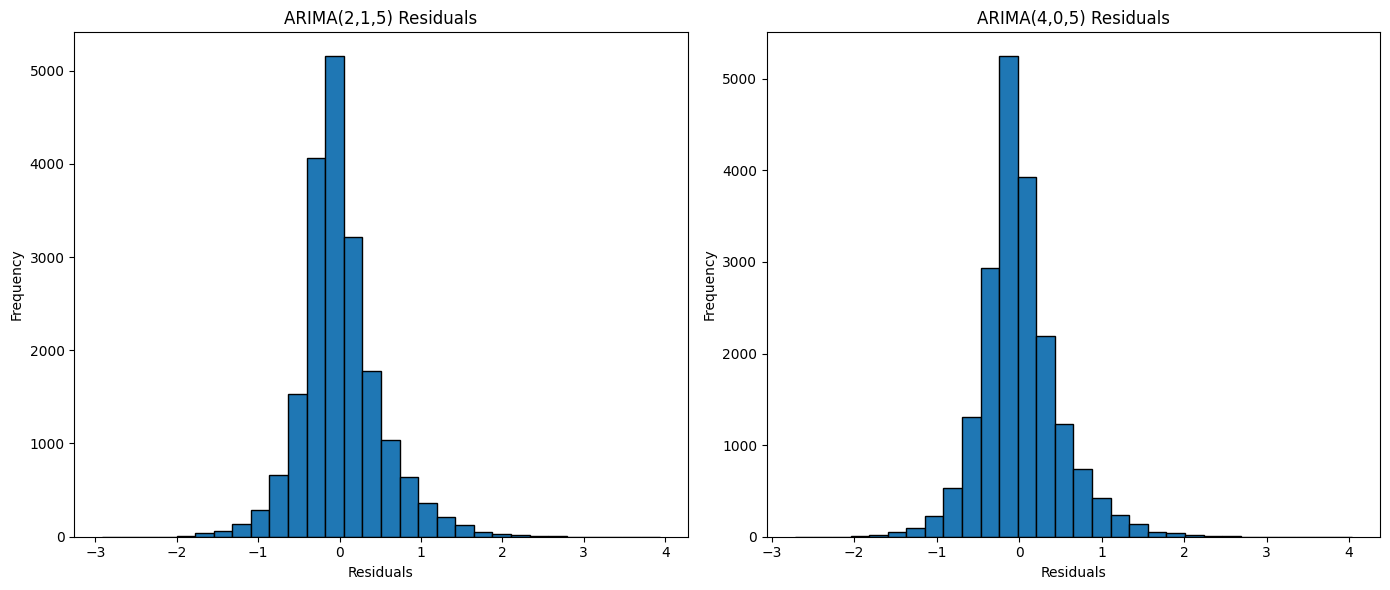

In [20]:
# comparison of the histograms

# residuals
residuals_215 = fit_215.resid
residuals_405 = fit_405.resid

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(residuals_215, bins=30, edgecolor='k')
plt.title('ARIMA(2,1,5) Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(residuals_405, bins=30, edgecolor='k')
plt.title('ARIMA(4,0,5) Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')



plt.tight_layout()
plt.show()

The residuals in a time series model are what is left over after fitting a model. The residuals are equal to the difference between the observations and the corresponding fitted values.

Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will have residuals with the following properties:

1. The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
2. The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

In [21]:
# statistical test and metricts to determine which model is better

import math 
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro

# mean of the residuals (should be 0)
mean1 = np.mean(residuals_215)
mean2 = np.mean(residuals_405)
#print(mean1, mean2)

# AIC (already done above) - writte about AIC in the report
aic1 = fit_215.aic
aic2 = fit_405.aic
#print(aic1, aic2)
# lower is better
if aic1 < aic2:
    print('ARIMA(2,1,5) is better based on AIC.')
else:
    print('ARIMA(4,0,5) is preferred based on AIC.')

# Ljung-Box test for autocorrelation - see model fit output

# BIC - see model fit output

ARIMA(4,0,5) is preferred based on AIC.


Mean Absolute Error: 0.3440126102182691
Mean Squared Error: 0.22547028043685166


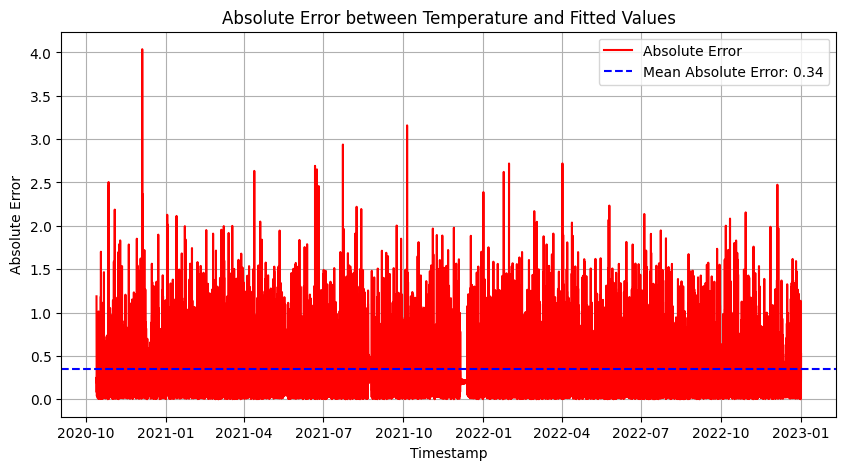

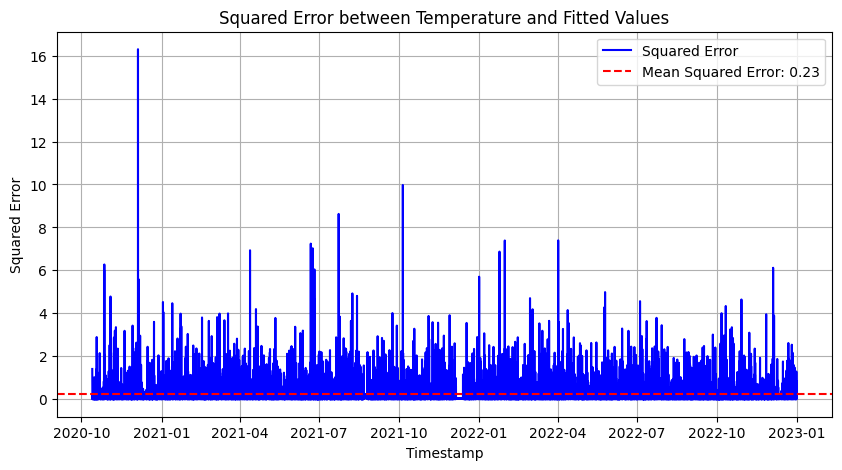

In [24]:
# absolute error comparison - actual data vs fitted model data

def calculate_errors(data, model): 
      # model are fitted values of a chosen model
  if isinstance(data, pd.Series) and isinstance(model, pd.Series):
        absolute_error = (data - model).abs()
        squared_error = (data - model) ** 2
  elif isinstance(data, np.ndarray) and isinstance(model, np.ndarray):
        absolute_error = np.abs(data - model)
        squared_error = (data - model) ** 2
  errors = pd.DataFrame({
        'absolute_error': absolute_error,
        'squared_error': squared_error
  })

  return errors

# (4,1,2) is the preferred, lets compare this data with actual data
# actual data - temperature_20_21_22
# fitted values data - fitted_values_412 

errors = calculate_errors(wind_speed_20_21_22, fitted_values_405 )

# mean errors
mean_absolute_error = errors['absolute_error'].mean()
mean_squared_error = errors['squared_error'].mean()
print("Mean Absolute Error:", mean_absolute_error)
print("Mean Squared Error:", mean_squared_error)

# plot of the absolute error
plt.figure(figsize=(10, 5))
plt.plot(errors['absolute_error'], label='Absolute Error', color='red')
plt.axhline(y=mean_absolute_error, color='blue', linestyle='--', label=f'Mean Absolute Error: {mean_absolute_error:.2f}')
plt.xlabel('Timestamp')
plt.ylabel('Absolute Error')
plt.title('Absolute Error between Temperature and Fitted Values')
plt.legend()
plt.grid(True)
plt.show()

# plot of the squared error
plt.figure(figsize=(10, 5))
plt.plot(errors['squared_error'], label='Squared Error', color='blue')
plt.axhline(y=mean_squared_error, color='red', linestyle='--', label=f'Mean Squared Error: {mean_squared_error:.2f}')
plt.xlabel('Timestamp')
plt.ylabel('Squared Error')
plt.title('Squared Error between Temperature and Fitted Values')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
    

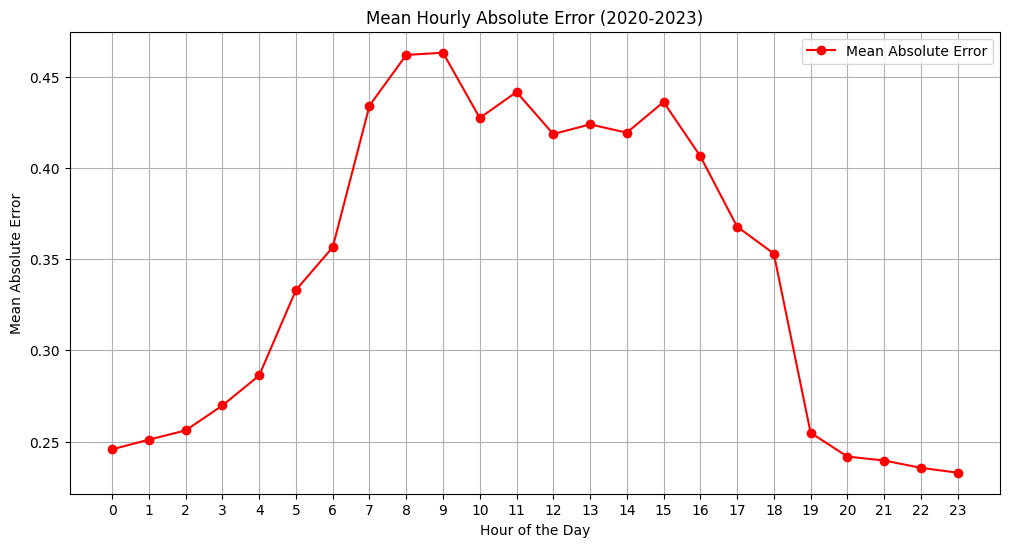

Hour
0     0.245791
1     0.251106
2     0.256167
3     0.269820
4     0.286278
5     0.333098
6     0.356475
7     0.434058
8     0.461811
9     0.463031
10    0.427306
11    0.441490
12    0.418476
13    0.423786
14    0.419250
15    0.436044
16    0.406353
17    0.367776
18    0.353006
19    0.254887
20    0.241833
21    0.239680
22    0.235687
23    0.232992
Name: absolute_error, dtype: float64


In [25]:
# mean hourly absolute errors

errors['Hour'] = errors.index.hour

# mean
mean_absolute_errors_by_hour = errors.groupby('Hour')['absolute_error'].mean()

# plot
plt.figure(figsize=(12, 6))
plt.plot(mean_absolute_errors_by_hour.index, mean_absolute_errors_by_hour, label='Mean Absolute Error', marker='o', color='red')

plt.xlabel('Hour of the Day')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Hourly Absolute Error (2020-2023)')
plt.legend(loc='upper right')
plt.grid(True)
plt.xticks(range(24))
plt.show()

print(mean_absolute_errors_by_hour)

In [22]:
# actual measurements for 1 day (24 steps) into the future
w_speed_hourly = wind_speed_hourly['WIND_SPEED']
actual_values_wind_speed_23 = w_speed_hourly['2023'].head(24)
print(actual_values_wind_speed_23)

2023-01-01 00:00:00+00:00    2.307500
2023-01-01 01:00:00+00:00    1.975000
2023-01-01 02:00:00+00:00    1.783333
2023-01-01 03:00:00+00:00    1.916667
2023-01-01 04:00:00+00:00    1.930000
2023-01-01 05:00:00+00:00    2.085833
2023-01-01 06:00:00+00:00    2.262500
2023-01-01 07:00:00+00:00    1.590000
2023-01-01 08:00:00+00:00    1.039167
2023-01-01 09:00:00+00:00    0.506667
2023-01-01 10:00:00+00:00    2.077500
2023-01-01 11:00:00+00:00    1.387500
2023-01-01 12:00:00+00:00    0.378333
2023-01-01 13:00:00+00:00    0.485833
2023-01-01 14:00:00+00:00    0.875000
2023-01-01 15:00:00+00:00    1.026667
2023-01-01 16:00:00+00:00    1.039167
2023-01-01 17:00:00+00:00    0.716667
2023-01-01 18:00:00+00:00    1.095000
2023-01-01 19:00:00+00:00    1.575000
2023-01-01 20:00:00+00:00    1.255000
2023-01-01 21:00:00+00:00    1.100000
2023-01-01 22:00:00+00:00    1.341667
2023-01-01 23:00:00+00:00    2.267500
Freq: H, Name: WIND_SPEED, dtype: float64


                             Actual  ARIMA(2,1,5)  ARIMA(4,0,5)  \
2023-01-01 00:00:00+00:00  2.307500      1.900904      1.787740   
2023-01-01 01:00:00+00:00  1.975000      1.822120      1.635959   
2023-01-01 02:00:00+00:00  1.783333      1.774416      1.601913   
2023-01-01 03:00:00+00:00  1.916667      1.724575      1.562988   
2023-01-01 04:00:00+00:00  1.930000      1.690285      1.555617   
2023-01-01 05:00:00+00:00  2.085833      1.660741      1.532620   
2023-01-01 06:00:00+00:00  2.262500      1.641376      1.531471   
2023-01-01 07:00:00+00:00  1.590000      1.623709      1.506829   
2023-01-01 08:00:00+00:00  1.039167      1.612931      1.497665   
2023-01-01 09:00:00+00:00  0.506667      1.602237      1.460822   
2023-01-01 10:00:00+00:00  2.077500      1.596377      1.436971   
2023-01-01 11:00:00+00:00  1.387500      1.589797      1.385158   
2023-01-01 12:00:00+00:00  0.378333      1.586734      1.347581   
2023-01-01 13:00:00+00:00  0.485833      1.582598      1.28512

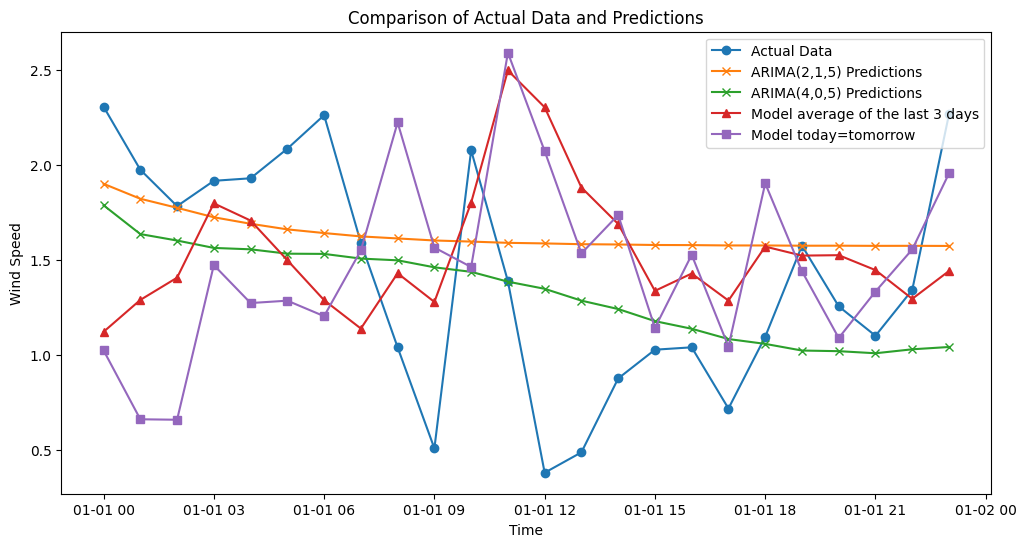

In [23]:
# comparing the models with the actual data
# change p,d,q to the best found

comparison_wind_speed = pd.DataFrame({
    'Actual': actual_values_wind_speed_23,
    'ARIMA(2,1,5)': forecast_values_215,
    'ARIMA(4,0,5)': forecast_values_405,
    'Model average of the last 3 days': last_3_wind_speed,
    'Model today=tomorrow': today_is_tomorrow_wind_speed
})

print(comparison_wind_speed)

plt.figure(figsize=(12,6))

plt.plot(comparison_wind_speed.index, comparison_wind_speed['Actual'], label='Actual Data', marker='o')
plt.plot(comparison_wind_speed.index, comparison_wind_speed['ARIMA(2,1,5)'], label='ARIMA(2,1,5) Predictions', marker='x')
plt.plot(comparison_wind_speed.index, comparison_wind_speed['ARIMA(4,0,5)'], label='ARIMA(4,0,5) Predictions', marker='x')
plt.plot(comparison_wind_speed.index, comparison_wind_speed['Model average of the last 3 days'], label='Model average of the last 3 days', marker='^')
plt.plot(comparison_wind_speed.index, comparison_wind_speed['Model today=tomorrow'], label='Model today=tomorrow', marker='s')

plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.title('Comparison of Actual Data and Predictions')
plt.legend()
plt.show()

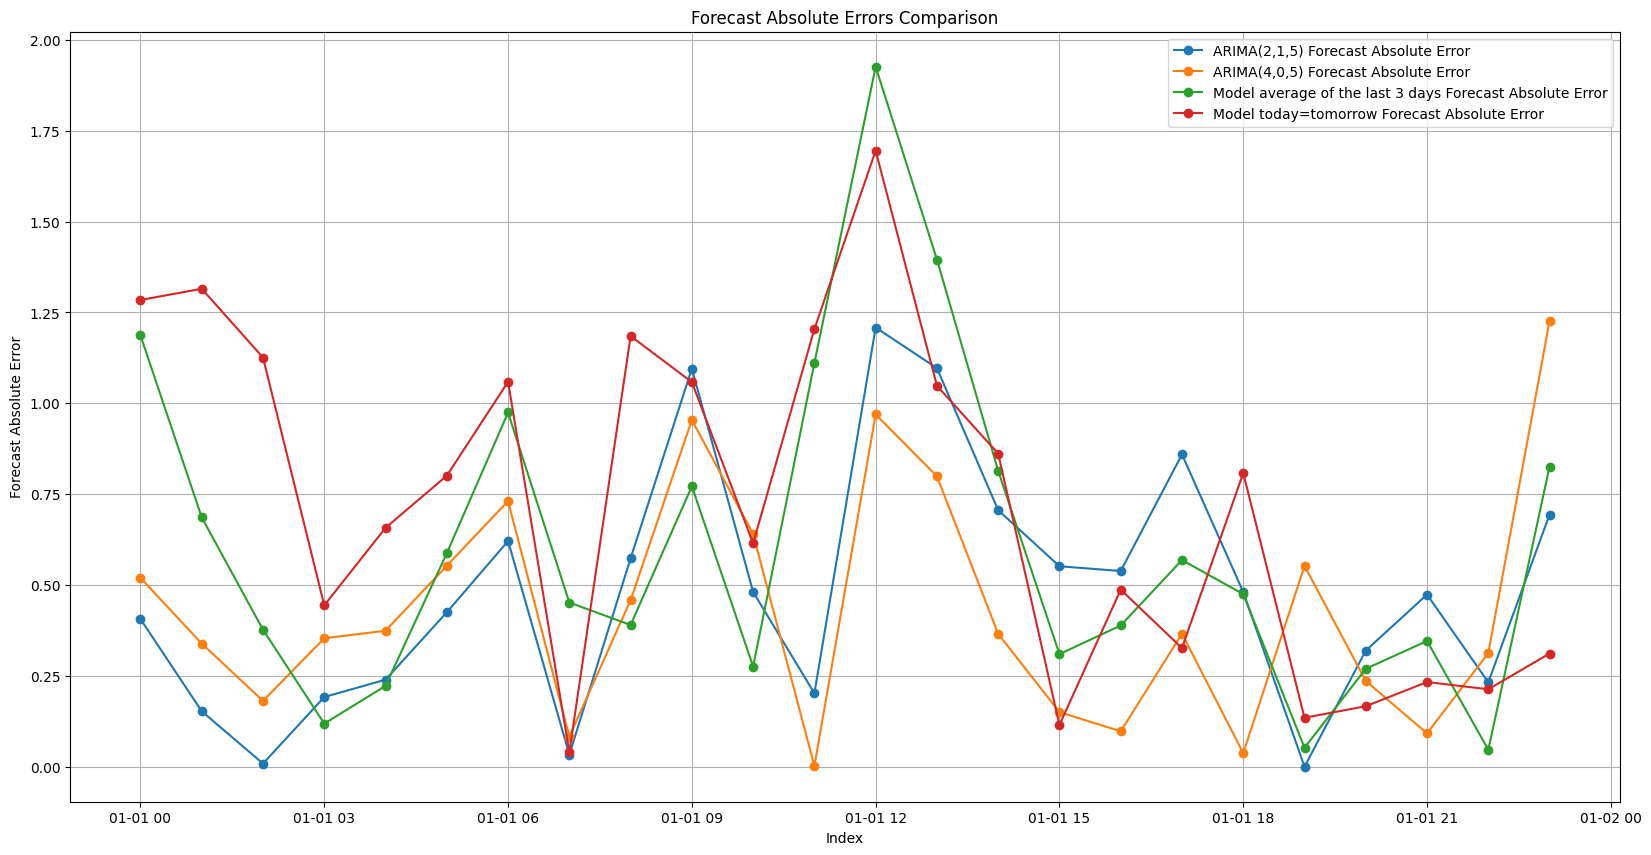

ARIMA(2,1,5) Forecast Absolute Error                        0.483138
ARIMA(4,0,5) Forecast Absolute Error                        0.433264
Model average of the last 3 days Forecast Absolute Error    0.607257
Model today=tomorrow Forecast Absolute Error                0.716319
dtype: float64


In [26]:
# 4 models' predictions compared to the actual data

# absolute errors of all the models
forecast_absolute_errors = pd.DataFrame()
for column in comparison_wind_speed.columns:
    if column != 'Actual':
        forecast_absolute_errors[column + ' Forecast Absolute Error'] = (comparison_wind_speed['Actual'] - comparison_wind_speed[column]).abs()

# plot
plt.figure(figsize=(20, 10))
for column in forecast_absolute_errors.columns:
    plt.plot(forecast_absolute_errors[column], label=column, marker='o')

plt.xlabel('Index')
plt.ylabel('Forecast Absolute Error')
plt.title('Forecast Absolute Errors Comparison')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# values 
#print(forecast_absolute_errors)

# mean errors
print(forecast_absolute_errors.mean())
